In [1]:
import os
import sys
sys.path.append(os.getcwd())
sys.path.insert(0, "../zeolite-property-prediction/code/")
sys.path.insert(0, "../zeolite-property-prediction/")


import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.optim import Adam, SGD

from torch.distributions import gumbel

import matplotlib.pyplot as plt
import matplotlib.ticker as tick
import matplotlib.patheffects as pe

from tqdm import tqdm

from scipy.stats import gaussian_kde
from sklearn.metrics import r2_score
from models.equivariant_mpnn import MPNNPORE
from utils.ZeoliteData import get_zeolite, get_data_pore, get_data_graph, get_data_megnet
from utils.dataloading import get_data, get_graph_data

In [2]:
from pygad import GA

In [3]:
import matplotlib as mpl

In [4]:
plt.rc('font', family='serif',)


In [5]:
from matplotlib import rc

In [6]:
data = get_zeolite('MOR', True)
    
ref = data['ref'] # reflections
tra = data['tra'] # translations
l = data['l'] # scale of the unit cell

# specific for MOR
atoms, hoa, X, A, d, X_pore, A_pore, d_pore, pore = get_data(l, 'MOR')
# hoa = hoa[:,0]

edges, idx1, idx2, idx2_oh = get_graph_data(A, d)
edges_sp, idx1_sp, idx2_sp, idx2_oh_sp = get_graph_data(A_pore, d_pore)
edges_ps, idx1_ps, idx2_ps, idx2_oh_ps = get_graph_data(A_pore.T, d_pore.T)

In [7]:
_, testloader, trainloader = get_data_pore(atoms, hoa, edges, pore, edges_sp, edges_ps, bs=32, random=True)

In [8]:
distance_matrix=d

In [9]:
hoa.shape

(5011, 2)

In [10]:
title_size=7.5
label_size=7

In [11]:
mpnn = MPNNPORE(idx1.to('cuda'), idx2.to('cuda'), idx2_oh.to('cuda'), X, X_pore, ref, tra,
                    idx1_sp.to('cuda'), idx2_sp.to('cuda'), idx2_oh_sp.to('cuda'), 
                    idx1_ps.to('cuda'), idx2_ps.to('cuda'), idx2_oh_ps.to('cuda'),
                    hid_size=[8]*6, site_emb_size=8, edge_emb_size=8, mlp_size=24,
                    centers=10, mx_d=6, width=1, pool='sum', pool_pore=True, out_size=2).to('cuda')


mpnn2 = MPNNPORE(idx1.to('cuda'), idx2.to('cuda'), idx2_oh.to('cuda'), X, X_pore, ref, tra,
                    idx1_sp.to('cuda'), idx2_sp.to('cuda'), idx2_oh_sp.to('cuda'), 
                    idx1_ps.to('cuda'), idx2_ps.to('cuda'), idx2_oh_ps.to('cuda'),
                    hid_size=[8]*6, site_emb_size=8, edge_emb_size=8, mlp_size=24,
                    centers=10, mx_d=6, width=1, pool='sum', pool_pore=True, site_pred=True, out_size=2).to('cuda')

In [12]:
def get_95_CI(x):
    
    ci = 1.96*np.std(x)/np.sqrt(len(x))
    return ci

In [13]:
_mae_p_hoa = []
_mae_p_henry = []
_mse_p_hoa = []
_mse_p_henry = []
_r2_p_hoa = []
_r2_p_henry = []


_mae_p2_hoa = []
_mse_p2_hoa = []
_mae_p2_henry = []
_mse_p2_henry = []
_r2_p2_hoa = []
_r2_p2_henry = []

for j in tqdm(range(1,11)):

    mpnn.load_state_dict(torch.load(f'model_data_random/MOR/1.0/pore/model_{j}/model.pth'))
    y_pred, y_true = mpnn.predict(testloader)
    y_true[:,1] = torch.log10(y_true[:,1])

    _mse = ((y_pred - y_true)**2)#.mean().item()
    _mae = (y_pred - y_true).abs()#.mean().item()

    _r2_hoa = r2_score(y_true[:,0].numpy(), y_pred[:,0].numpy())
    _r2_henry = r2_score(y_true[:,1].numpy(), y_pred[:,1].numpy())

    _mae_hoa = _mae[:,0].mean().item()
    _mae_henry = _mae[:,1].mean().item()
    _mse_hoa = _mse[:,0].mean().item()
    _mse_henry = _mse[:,1].mean().item()
    
    _mae_p_hoa.append(_mae_hoa)
    _mae_p_henry.append(_mae_henry)
    _mse_p_hoa.append(_mse_hoa)
    _mse_p_henry.append(_mse_henry)
    _r2_p_hoa.append(_r2_hoa)
    _r2_p_henry.append(_r2_henry)
    mpnn2.load_state_dict(torch.load(f'model_data_random2/MOR/1.0/pore/model_{j}/model.pth'))
    y_pred, y_true = mpnn2.predict(testloader)
    y_true[:,1] = torch.log10(y_true[:,1])
    
    _mse = ((y_pred - y_true)**2)#.mean().item()
    _mae = (y_pred - y_true).abs()#.mean().item()


    _r2_hoa = r2_score(y_true[:,0].numpy(), y_pred[:,0].numpy())
    _r2_henry = r2_score(y_true[:,1].numpy(), y_pred[:,1].numpy())

    _mae_hoa = _mae[:,0].mean().item()
    _mae_henry = _mae[:,1].mean().item()
    _mse_hoa = _mse[:,0].mean().item()
    _mse_henry = _mse[:,1].mean().item()
    
    
    _mae_p2_hoa.append(_mae_hoa)
    _mae_p2_henry.append(_mae_henry)
    _mse_p2_hoa.append(_mse_hoa)
    _mse_p2_henry.append(_mse_henry)
    _r2_p2_hoa.append(_r2_hoa)
    _r2_p2_henry.append(_r2_henry)

mae_p_hoa  = np.mean(_mae_p_hoa)
mse_p_hoa = np.mean(_mse_p_hoa)
r2_p_hoa = np.mean(_r2_p_hoa)
mae_p2_hoa  = np.mean(_mae_p2_hoa)
mse_p2_hoa = np.mean(_mse_p2_hoa)
r2_p2_hoa = np.mean(_r2_p2_hoa)

mae_p_henry  = np.mean(_mae_p_henry)
mse_p_henry = np.mean(_mse_p_henry)
r2_p_henry = np.mean(_r2_p_henry)
mae_p2_henry  = np.mean(_mae_p2_henry)
mse_p2_henry = np.mean(_mse_p2_henry)
r2_p2_henry = np.mean(_r2_p2_henry)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:20<00:00,  2.01s/it]


In [14]:
maes = [_mae_p_hoa, _mae_p2_hoa, _mae_p_henry, _mae_p2_henry]
mses = [_mse_p_hoa, _mse_p2_hoa, _mse_p_henry, _mse_p2_henry]
r2s = [_r2_p_hoa, _r2_p2_hoa, _r2_p_henry, _r2_p2_henry]

In [15]:
df = pd.DataFrame(columns = ['MAE','MSE','R2'], index=['EPCN (hoa)','Ours (hoa)','EPCN (henry)', 'Ours (henry)'])
for i in range(len(df.index)):

    mu_a = np.mean(maes[i]).round(2)
    mu_s = np.mean(mses[i]).round(2)
    mu_r = np.mean(r2s[i]).round(2)
    
    ci_a = get_95_CI(maes[i]).round(2)
    ci_s = get_95_CI(mses[i]).round(2)
    ci_r = get_95_CI(r2s[i]).round(2)
    
    a = fr'{mu_a} $$\pm$$ {ci_a}'
    s = fr'{mu_s} $$\pm$$ {ci_s}'
    r = fr'{mu_r} $$\pm$$ {ci_r}'
    
    df.loc[df.index[i]] = [a,s,r]

In [16]:
df

,MAE,MSE,R2
EPCN (hoa),0.89 $$\pm$$ 0.07,1.42 $$\pm$$ 0.21,0.92 $$\pm$$ 0.01
Ours (hoa),0.86 $$\pm$$ 0.02,1.36 $$\pm$$ 0.06,0.92 $$\pm$$ 0.0
EPCN (henry),0.08 $$\pm$$ 0.0,0.01 $$\pm$$ 0.0,0.96 $$\pm$$ 0.0
Ours (henry),0.08 $$\pm$$ 0.01,0.01 $$\pm$$ 0.0,0.95 $$\pm$$ 0.01


In [17]:
best_idx = np.argmin(_mae_p2_hoa)
mpnn2.load_state_dict(torch.load(f'model_data_random2/MOR/1.0/pore/model_{best_idx+1}/model.pth'))
y_pred, y_true = mpnn2.predict(testloader)
y_pred = y_pred.numpy()
y_true = y_true.numpy()
y_true[:,1] = np.log10(y_true[:,1])

In [18]:
np.save('pred_mor.npy', y_pred)
np.save('true_mor.npy', y_true)
np.save('ats_mor.npy',testloader.dataset.X.numpy())

In [19]:
data['l']

array([18.256, 20.534,  7.542])

In [20]:
def get_co2(file, l=l):
    with open(file, 'r') as f:
        lines = f.readlines()
    coordinates = []

    for line in lines:
        if line.startswith('ATOM'):
            parts = line.split()
            if parts[2] == 'C':
                x_coord, y_coord, z_coord = map(float, parts[4:7])
                coordinates.append((x_coord, y_coord, z_coord))
    coordinates = torch.tensor(coordinates)
    coordinates = torch.remainder(coordinates, l)/l
    
    return coordinates

def get_atoms(file):

    with open(file) as f:
        lines = f.readlines()
    lines = [i.strip().split() for i in lines]
    lines = [i for i in lines if len(i)>1]


    at_pos = [i[1:5] for i in lines if i[1] in ['Si', 'Al']]
    atom = np.array([1 if i[0]=='Al' else 0 for i in at_pos])
    X = np.array([list(map(float, i[1:])) for i in at_pos])
    return torch.tensor(atom), torch.tensor(X)    

In [21]:
def get_edges(X,A):

    edge_x, edge_y = [],[]
    
    for i in range(A.shape[0]):
        for j in range(A.shape[0]):
            if A[i,j] == 1:
                ix, iy = X[i,[0,1]].copy()

                jx, jy = X[j,[0,1]].copy()
            
                if jx - ix > 0.5:
                    jx -= 1
                elif jx - ix < -0.5:
                    jx += 1

                if jy - iy > 0.5:
                    jy -= 1
                elif jy - iy < -0.5:
                    jy += 1

                
                
                edge_x.append((ix,jx))
                edge_y.append((iy,jy))
                
                
    return edge_x, edge_y

def plot_edges(X,A,ax):

    ex, ey = get_edges(X,A)    
    for i in range(len(ex)):

        # ax.plot(ex[i], ey[i], c='black', zorder=-100)
        line = ax.plot(ex[i], ey[i], c='grey', lw=2, zorder=-1)
        ax.plot(ex[i], ey[i], lw=3, c='black', zorder=-2)
        
    # ax.scatter(eix, eiy)
    # ax.scatter(ejx, ejy, s=100)
    

In [22]:
import matplotlib.colors as mcolors
high_color = 'blue'

# Create a custom colormap that transitions from white (0) to the specified color
cmap = mcolors.LinearSegmentedColormap.from_list('custom_colormap', [(0, 'white'), (1, high_color)])

In [23]:
atoms.shape, hoa.shape

((5011, 48), (5011, 2))

In [24]:
X.shape, hoa.shape

((48, 3), (5011, 2))

In [25]:
def plot_co2(sample_idx):
    assert len(sample_idx) % 2 == 0
    ncols=2*len(sample_idx)//2
    nrows=len(sample_idx)//2
    # 18.256/4, 20.534/4
    fig, ax = plt.subplots(ncols=ncols, nrows=nrows, figsize=(ncols*18.256/8,nrows*20.534/8), constrained_layout=True)
    
    for i in range(len(sample_idx)):
        row = i//2
        col = (i % 2) * 2
        idx = sample_idx[i]
        a, _ = get_atoms(f'C:/users/20175552/code/MCMC_gen/data/co2_cifs/MOR_{idx}.cif')
        co2 = get_co2(f'C:/users/20175552/code/MCMC_gen/data/co2/CO2_{idx}.pdb', torch.tensor(data['l']))
    
        #print(sum((atoms==a.numpy()).all(1)))
    
        true_hoa = hoa[(atoms==a.numpy()).all(1), 0]
        
        mpnn2.eval()
        with torch.no_grad():
            _X[0] = a.unsqueeze(-1)
            hid = mpnn2.forward(_X.float().cuda(), _bonds.float().cuda(), _X_p.float().cuda(), _bonds_sp.float().cuda(), _bonds_ps.float().cuda())[0].cpu().numpy()
        print(hid.shape)
        hid = hid[:,0]
        print(hid)
        pred_hoa = sum(hid)
        
        x = co2[:,0]
        y = co2[:,1]
        
    
        
        plot_edges(X,A, ax[row,col])
        plot_edges(X,A, ax[row,col+1])
    
        # xy = np.mod(np.vstack([x,y]))
        # z = gaussian_kde(xy)(xy)
    
        # Sort the points by density, so that the densest points are plotted last
        # idx = z.argsort()
        # x, y, z = x[idx], y[idx], z[idx]
        ax[row,col].hist2d(x,y, bins=75, cmap=cmap, zorder=-1000, vmin=0, vmax=48)
        # h = ax[0].hist2d(x,y, bins=75, cmap=cmap, zorder=-1000)
        # print(h[0].max())
        # ax[0].scatter(x, y, c=z)
        ax[row,col].scatter(X[:,0], X[:,1], c= a,edgecolors='black', cmap='prism', s=90)
        ax[row,col].set_xlim(0,1)
        ax[row,col].set_ylim(0,1)
        ax[row,col].set_xticks([],[])
        ax[row,col].set_yticks([],[])
    
    
        ax[row,col+1].scatter(X[:,0], X[:,1], c= a,edgecolors='black', cmap='prism', s=90)
        pr = ax[row,col+1].scatter(X_pore[:,0], X_pore[:,1], c=hid , s=90, cmap='Reds',edgecolors='black', vmin=0, vmax=10, marker='s')
        ax[row,col+1].scatter(X_pore[:,0]+1, X_pore[:,1], c=hid , s=90, cmap='Reds',edgecolors='black', vmin=0, vmax=10, marker='s')
        ax[row,col+1].scatter(X_pore[:,0], X_pore[:,1]+1, c=hid , s=90, cmap='Reds',edgecolors='black', vmin=0, vmax=10, marker='s')
        ax[row,col+1].scatter(X_pore[:,0]+1, X_pore[:,1]+1, c=hid , s=90, cmap='Reds',edgecolors='black', vmin=0, vmax=10, marker='s')
        ax[row,col+1].set_xlim(0,1)
        ax[row,col+1].set_ylim(0,1)
        ax[row,col+1].set_xticks([],[])
        ax[row,col+1].set_yticks([],[])
    
        ax[row,col].set_title(f'MC HoA: {true_hoa[0]:.2f} kJ/mol')
        ax[row,col+1].set_title(f'ML HoA: {pred_hoa:.2f} kJ/mol')

        if col == 2:
            plt.colorbar(pr, ax=ax[row,3])
    
    line = plt.Line2D((.4739,.4739),(0,1.), color="grey", linewidth=1.5, linestyle='--')
    fig.add_artist(line)
    fig.savefig(f'figures/co2emb.pdf', dpi=900, bbox_inches='tight')
    fig.savefig(f'figures/co2emb.png', dpi=900, bbox_inches='tight')

In [26]:
_X, _bonds, _X_p, _bonds_sp, _bonds_ps, _y = next(iter(testloader))

In [27]:
mpnn2.load_state_dict(torch.load(f'model_data_random2/MOR/1.0/pore/model_6/model.pth'))
pred = mpnn2.forward(_X.float().cuda(), _bonds.float().cuda(), _X_p.float().cuda(), _bonds_sp.float().cuda(), _bonds_ps.float().cuda())

In [28]:
# 6

In [29]:
sample_idx = [752, 789, 1200, 1250]
# sample_idx = [752, 789, 1200, 1119]

(16, 2)
[7.4430146 9.609591  2.7411907 3.3771975 1.5505866 1.6586254 1.6641908
 1.3458539 1.5947297 1.7114955 1.4853786 1.2786679 1.1988726 1.2033457
 1.0980209 0.9934205]
(16, 2)
[6.359609   6.502408   2.7879813  3.1143687  1.3105737  1.6681277
 1.7888876  1.9263582  1.6343149  1.6589468  1.1038043  1.103475
 1.0045791  1.468432   1.042555   0.99894834]
(16, 2)
[7.019181  7.102861  3.0061789 2.89903   1.441225  1.8677434 1.883712
 1.8047975 1.5364497 1.3493949 1.66966   1.5583357 1.0410708 1.2278694
 1.1967913 1.0692894]
(16, 2)
[6.826108  7.873198  2.9836888 3.405855  1.2200695 1.4232978 1.3922386
 1.3439146 1.7716522 1.7582523 1.8181224 2.0314462 1.3882272 1.0363394
 1.0297021 1.5105927]


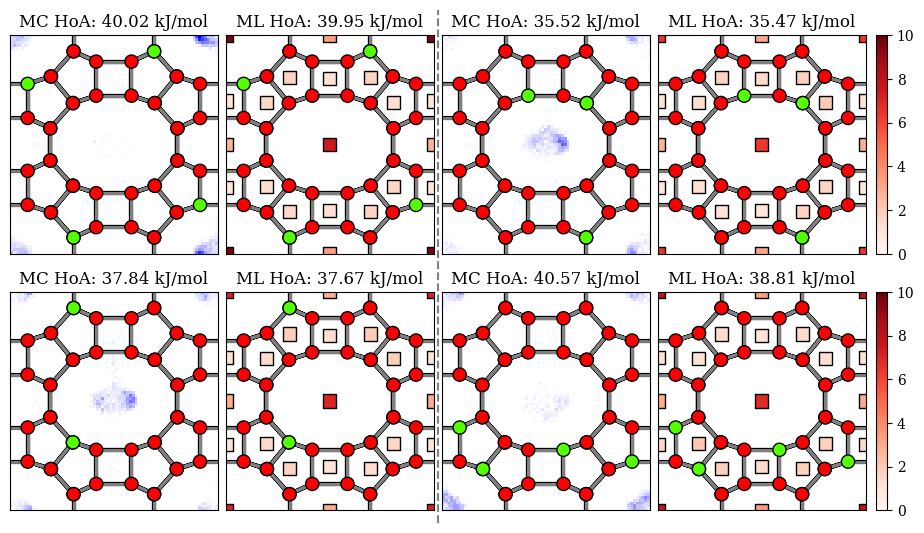

In [30]:
plot_co2(sample_idx)

In [82]:
best_idx

4

In [39]:
from scipy.interpolate import griddata

In [87]:
color2 = np.zeros((X_pore.shape[0],))
for i in range(len(X_pore)):
    
    for j in [0,2,4,-1]:
        
        for k in range(ref.shape[0]):
            
            if np.abs(X_pore[i] - (np.mod(ref[k]*X_pore[j] + tra[k], 1))).sum() < 0.001:
                
                color2[i] = j
                
                break

In [88]:
blaa = {'a':1}

'b' in blaa

False

In [89]:
ce_dict = {}
row, col = np.nonzero(A)
n_c = 0
for i in range(len(row)):
    
    added = False
    
    r,c = row[i], col[i]
    
    for j in ce_dict:
        
        if added: break
        
        test = ce_dict[j][0]
        
        test_r = X[test[0]]
        test_c = X[test[1]]
        
        
        for k in range(ref.shape[0]):
            
            r1 = np.mod(ref[k]*X[r] + tra[k], 1)
            r2 = np.mod(ref[k]*X[c] + tra[k], 1)
            
            if np.abs(r1-test_r).sum() < 0.001 and np.abs(r2-test_c).sum() < 0.001:
                
                ce_dict[j].append((r,c))
                
                added = True
                break
        
    if not added:
        ce_dict[n_c] = [(r,c)]
        n_c += 1

In [90]:
cp_dict = {}
row, col = np.nonzero(A_pore)
n_c = 0
for i in range(len(row)):
    
    added = False
    
    r,c = row[i], col[i]
    
    for j in cp_dict:
        
        if added: break
        
        test = cp_dict[j][0]
        
        test_r = X[test[0]]
        test_c = X_pore[test[1]]
        
        
        for k in range(ref.shape[0]):
            
            r1 = np.mod(ref[k]*X[r] + tra[k], 1)
            r2 = np.mod(ref[k]*X_pore[c] + tra[k], 1)
            
            if np.abs(r1-test_r).sum() < 0.001 and np.abs(r2-test_c).sum() < 0.001:
                
                cp_dict[j].append((r,c))
                
                added = True
                break
        
    if not added:
        cp_dict[n_c] = [(r,c)]
        n_c += 1

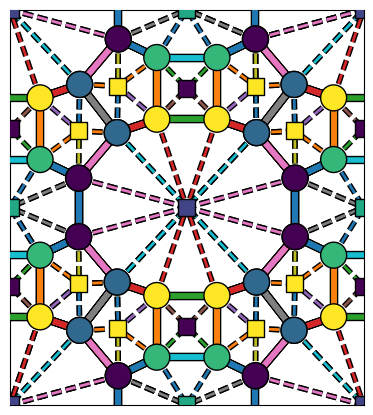

In [92]:
plt.figure(figsize=(18.256/4, 20.534/4))
for i in ce_dict:
    x = 0
    for j in ce_dict[i]:
        
        x1, x2 = X[j[0]].copy(), X[j[1]].copy()
        
        d = x2-x1
        
        for _d in range(3):
            
            if d[_d] > 0.5:
                
                x2[_d] -= 1
            
            elif d[_d] < -.5:
                
                x2[_d] += 1
            
        
        
        
        if x == 0:
            
            line = plt.plot([x1[0], x2[0]], [x1[1], x2[1]], lw=4, zorder=5)
            plt.plot([x1[0], x2[0]], [x1[1], x2[1]], lw=6, c='black', zorder=4)
        
        plt.plot([x1[0], x2[0]], [x1[1], x2[1]], c= line[0].get_c(),lw=4, zorder=5)
        plt.plot([x1[0], x2[0]], [x1[1], x2[1]], c= 'black',lw=6, zorder=4)
        x+=1
        
        
for i in cp_dict:
    x = 0
    for j in cp_dict[i]:
        
        x1, x2 = X[j[0]].copy(), X_pore[j[1]].copy()
        
        d = x2-x1
        
        for _d in range(3):
            
            if d[_d] > 0.5:
                
                x2[_d] -= 1
            
            elif d[_d] < -.5:
                
                x2[_d] += 1
            
        
        
        
        if x == 0:
            line = plt.plot([x1[0], x2[0]], [x1[1], x2[1]],lw=2,ls='--', path_effects=[pe.Stroke(linewidth=4, foreground='black'), pe.Normal()])
        
        plt.plot([x1[0], x2[0]], [x1[1], x2[1]], c= line[0].get_c(),lw=2,ls='--', path_effects=[pe.Stroke(linewidth=4, foreground='black'), pe.Normal()])
        #     line = plt.plot([x1[0], x2[0]], [x1[1], x2[1]],lw=2,ls='--', path_effects=[pe.Stroke(linewidth=4, foreground='black')])
        
        # plt.plot([x1[0], x2[0]], [x1[1], x2[1]], c= line[0].get_c(),lw=2,ls='--', path_effects=[pe.Stroke(linewidth=4, foreground='black')])
        x+=1
        

plt.scatter(X_pore[:,0], X_pore[:,1], s=150, zorder=10, c=color2, marker='s', edgecolors='black')
plt.scatter(X_pore[:,0]+1, X_pore[:,1], s=150, zorder=10, c=color2, marker='s', edgecolors='black')
plt.scatter(X_pore[:,0], X_pore[:,1]+1, s=150, zorder=10, c=color2, marker='s', edgecolors='black')
plt.scatter(X_pore[:,0]+1, X_pore[:,1]+1, s=150, zorder=10, c=color2, marker='s', edgecolors='black')
plt.xlim(0,1)
plt.ylim(0,1)
plt.xticks([],[])
plt.yticks([],[])
plt.scatter(X[:,0], X[:,1], c=color, s=350, zorder=10, edgecolors='black')
# plt.scatter(X[:,0], X[:,1], c='black', s=500, zorder=9)
plt.savefig('figures/weight_sharing_pore_mor.pdf', bbox_inches='tight', dpi=1200);
plt.savefig('figures/weight_sharing_pore_mor.png', bbox_inches='tight', dpi=1200);

In [297]:
atsum = testloader.dataset.X.sum((1,2))

In [298]:
hoa_test = testloader.dataset.y

In [299]:
uniq = atsum.unique()

In [300]:
hoa_min = np.zeros_like(uniq, dtype=float)
hoa_max = np.zeros_like(uniq, dtype=float)

In [301]:
for ue in range(len(uniq)):
    hoa_min[ue] = hoa_test[atsum==uniq[ue]].min()
    hoa_max[ue] = hoa_test[atsum==uniq[ue]].max()

In [302]:
uniq[np.logical_and(hoa_min < 30, hoa_max > 30)]

tensor([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

In [315]:
class GeneticNet(nn.Module):

    def __init__(self, mpnn, edges, pore, bonds_sp, bonds_ps):
        
        super().__init__()
        self.bonds = edges[None].float().cuda().repeat(2,1,1)
        self.sites_p = torch.tensor(pore[None]).float().cuda().repeat(2,1,1)
        self.bonds_sp = edges_sp[None].float().cuda().repeat(2,1,1)
        self.bonds_ps = edges_ps[None].float().cuda().repeat(2,1,1)

        self.mpnn = mpnn

    @torch.no_grad()
    def forward(self, atoms):
        return self.mpnn(atoms, self.bonds, self.sites_p, self.bonds_sp, self.bonds_ps)[0,:,0].sum()

In [316]:
beta = 1
def fitness_function(ga_instance, solution, solution_idx):
    atoms = torch.tensor(solution)[None,:,None].repeat(2,1,1).float().cuda()
    gen_net.eval()
    with torch.no_grad():
        curr_hoa = gen_net.forward(atoms).item()
    fitness = - (curr_hoa-target_hoa)**2 - beta*sum(solution)
    return fitness

In [317]:
target_hoa = 45

In [318]:
# n_pops = 32
# initial_population = np.zeros((n_pops, 48))

In [319]:
gen_net = GeneticNet(mpnn2, edges, pore, edges_sp, edges_ps,).cuda()

In [324]:
struct_per_hoa = 10
target_hoas = np.arange(30, 56)

In [325]:
new_structures = np.zeros((struct_per_hoa*len(target_hoas), 48))
pred_hoas = np.zeros((struct_per_hoa*len(target_hoas)))

In [326]:
for i in tqdm(range(len(target_hoas))):
    for j in range(struct_per_hoa):

        target_hoa = target_hoas[i]
        n_pops = 32
        initial_population = np.zeros((n_pops, 48))
        for k in range(len(initial_population)):
            n_atoms = uniq[np.logical_and(hoa_min <= target_hoa, hoa_max >= target_hoa)]
            if target_hoa > hoa_max.max():
                n_atoms=[12]
            elif target_hoa < hoa_min.min():
                n_atoms=[0]
            n = np.random.choice(n_atoms)
            idxes = np.random.choice(np.arange(48), size=n, replace=False)
        
            for l in idxes:
                initial_population[k,l] = 1
        
        ga_instance = GA(num_generations=50,
                 num_parents_mating=2,
                 initial_population=initial_population,
                 fitness_func=fitness_function,
                 crossover_probability=0.2,
                 keep_elitism=5,
                 save_best_solutions=True,
                 gene_space=[0, 1])
        
        ga_instance.run()
        solution = ga_instance.best_solutions[-1]
        atoms = torch.tensor(solution)[None,:,None].repeat(2,1,1).float().cuda()
        gen_net.eval()
        
        curr_hoa = gen_net.forward(atoms).item()

        idx = i*struct_per_hoa + j
        new_structures[idx] = solution
        pred_hoas[idx] = curr_hoa



100%|███████████████████████████████████████████████████████████████████████████████| 26/26 [2:07:05<00:00, 293.27s/it]


In [327]:
np.save('structures3.npy', new_structures)
np.save('pred_hoas3.npy', pred_hoas)

In [328]:
t_h = np.repeat(target_hoas, 10)

(array([ 1.,  0.,  0.,  1.,  2.,  1.,  0.,  4.,  5.,  6.,  1.,  6.,  6.,
         5.,  4.,  7.,  5.,  2.,  3.,  7.,  5.,  8.,  8.,  9.,  9., 21.,
        58., 44., 12.,  6.,  2.,  0.,  3.,  1.,  1.,  0.,  0.,  0.,  0.,
         1.,  0.,  0.,  1.,  2.,  0.,  0.,  1.,  1.,  0.,  1.]),
 array([-1.782547  , -1.71624157, -1.64993614, -1.58363071, -1.51732529,
        -1.45101986, -1.38471443, -1.318409  , -1.25210358, -1.18579815,
        -1.11949272, -1.05318729, -0.98688187, -0.92057644, -0.85427101,
        -0.78796558, -0.72166016, -0.65535473, -0.5890493 , -0.52274387,
        -0.45643845, -0.39013302, -0.32382759, -0.25752216, -0.19121674,
        -0.12491131, -0.05860588,  0.00769955,  0.07400497,  0.1403104 ,
         0.20661583,  0.27292126,  0.33922668,  0.40553211,  0.47183754,
         0.53814297,  0.60444839,  0.67075382,  0.73705925,  0.80336468,
         0.8696701 ,  0.93597553,  1.00228096,  1.06858639,  1.13489182,
         1.20119724,  1.26750267,  1.3338081 ,  1.40011353,

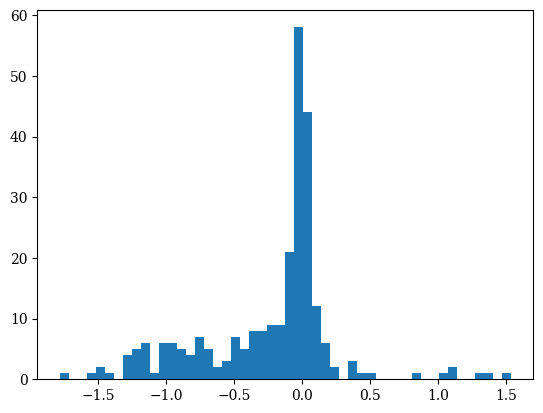

In [329]:
plt.hist(pred_hoas - t_h, bins=50)

In [330]:
with open('MOR_843.cif', 'r') as f:
    lines = f.readlines()

In [331]:
def create_cif(ex_cif, atoms, target_cif):

    with open(ex_cif, 'r') as f:
        lines = f.readlines()

    cnt = 0
    for i in range(len(lines)):

        trgt = 'Al' if atoms[cnt] == 0 else 'Si'
        rplc = 'Al' if trgt =='Si' else 'Si'

        
        
        if lines[i].startswith('Si') or lines[i].startswith('Al'):

            lines[i] = lines[i].replace(trgt, rplc)
            cnt += 1 

    with open(target_cif, 'w') as f:
        f.writelines(lines)

In [332]:
for i in range(len(new_structures)):

    create_cif('MOR_843.cif', new_structures[i], f'GA_mors_3/MOR_{i}.cif')

In [92]:
create_cif('MOR_843.cif', new_structures[0], 'MOR_test.cif')